In [1]:
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


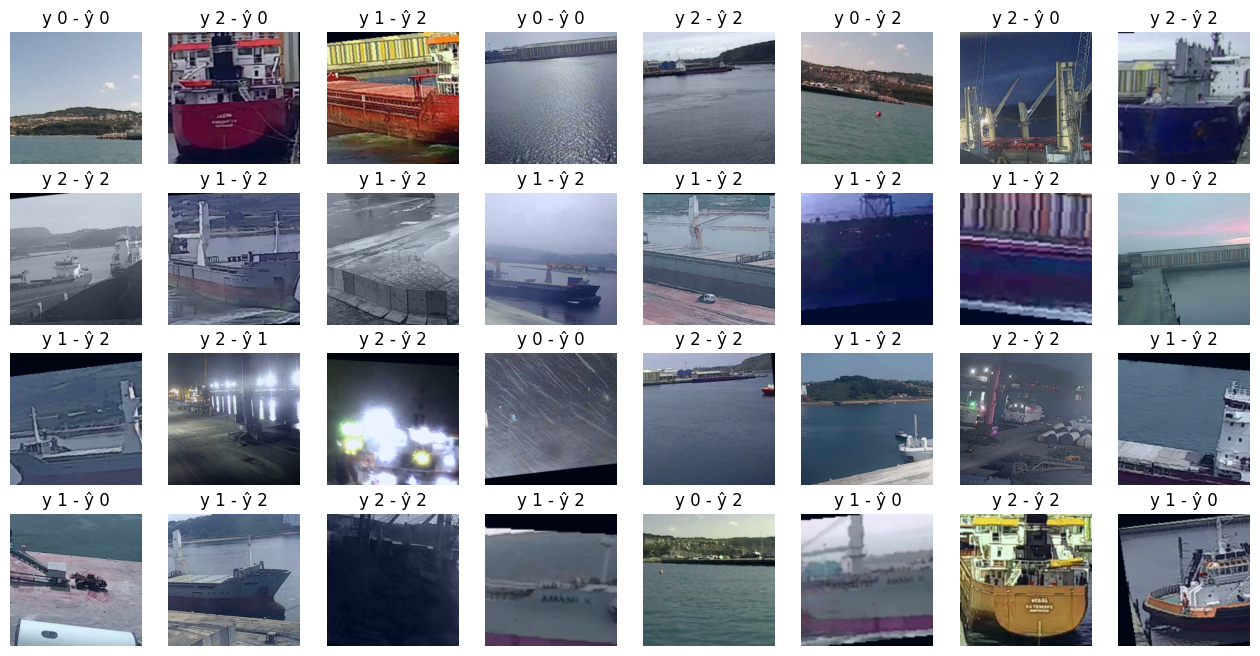

Using device: MPS


Evaluating: 100%|█████████████████| 1/1 [00:10<00:00, 10.77s/it]

Test Accuracy: 0.3390
F1 Score: 0.3317


In [2]:
from ship_classifier import ShipDataset, ShipClassifier, plotgrid
import scipy

dataAugmentation = True
docked=True
pretrained=True

classifier = ShipClassifier(pretrained=pretrained,docked=docked)
#classifier.load_model('modelparams')

classifier.model.to('mps')

trainset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=True, dataAugmentation=dataAugmentation, docked=docked)
testset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=False, dataAugmentation=False, docked=docked)

testloader = DataLoader(
        testset, 
        batch_size=512, 
        num_workers=8
    )

plotgrid(classifier,trainset)

test_acc, test_accuracies, f1, cm = classifier.test_model(testloader)

In [4]:
test_acc, test_accuracies, f1, cm = classifier.test_model(testloader)

NameError: name 'testloader' is not defined

[0.03478815 0.40055132 0.5646605 ]


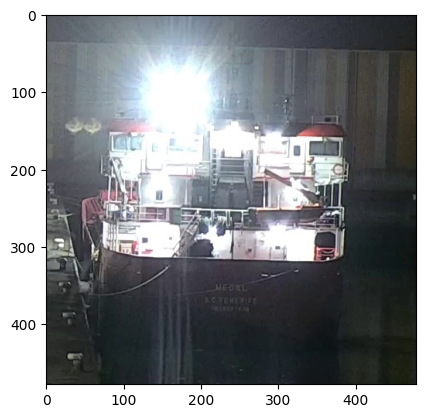

In [3]:
im = plt.imread('imagen2.jpg')
plt.imshow(im)
classifier.model.to('mps')
#classifier.new_dense_layer.to('mps')
#classifier.final_layer.to('mps')
im = torch.permute(torch.tensor(np.expand_dims(im,0),dtype=torch.float32),(0,3,1,2)).to('mps')

print(classifier.model(im)[0].cpu().detach().numpy())

In [19]:

classifier.model(im)

/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.3527, 0.3280, 0.3193]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [7]:
np.random.choice(np.arange(len(trainset)),8 * 4)

array([ 21,  44,  57,  59,  22,   4, 110,  98,   3,  62, 115,  46,  37,
        75,  76,  18,  93, 110, 102,  59,  49,  23,  81,   7,  61,  63,
        48, 124,   0, 106, 105,  11])